<a href="https://colab.research.google.com/github/Amir-Kermanshahani/Quantum_Programming/blob/main/Optimization/SPSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Optimizing Simultaneous perturbation stochastic approximation (SPSA) to calculate gradients of a circuit in PennyLane

In [ ]:
!pip install pennylane_qiskit

In [4]:
import pennylane as qml
from pennylane import numpy as np
from pennylane_qiskit import AerDevice

num_wires = 4
num_layers = 5

device = AerDevice(wires=num_wires, shots=1000)

ansatz = qml.StronglyEntanglingLayers

all_pauliz_tensor_prod = qml.prod(*[qml.PauliZ(i) for i in range(num_wires)])


def circuit(param):
    ansatz(param, wires=list(range(num_wires)))
    return qml.expval(all_pauliz_tensor_prod)


cost_function = qml.QNode(circuit, device)

np.random.seed(50)

param_shape = ansatz.shape(num_layers, num_wires)
init_param = np.random.normal(scale=0.1, size=param_shape, requires_grad=True)

In [6]:
# Defining a function to run the optimizer and log the resources used
def run_optimizer(opt, cost_function, init_param, num_steps, interval, execs_per_step):
    # Copy the initial parameters to make sure they are never overwritten
    param = init_param.copy()

    # Obtain the device used in the cost function
    dev = cost_function.device

    # Initialize the memory for cost values during the optimization
    cost_history = []
    # Monitor the initial cost value
    cost_history.append(cost_function(param))
    exec_history = [0]

    print(
        f"\nRunning the {opt.__class__.__name__} optimizer for {num_steps} iterations."
    )
    for step in range(num_steps):
        # Print out the status of the optimization
        if step % interval == 0:
            print(
                f"Step {step:3d}: Circuit executions: {exec_history[step]:4d}, "
                f"Cost = {cost_history[step]}"
            )

        # Perform an update step
        param = opt.step(cost_function, param)

        # Monitor the cost value
        cost_history.append(cost_function(param))
        exec_history.append((step + 1) * execs_per_step)

    print(
        f"Step {num_steps:3d}: Circuit executions: {exec_history[-1]:4d}, "
        f"Cost = {cost_history[-1]}"
    )
    return cost_history, exec_history

In [7]:
# Configuring the optimizer hyperparameters and running the optimizer
num_steps_spsa = 200
opt = qml.SPSAOptimizer(maxiter=num_steps_spsa, c=0.15, a=0.2)
# We spend 2 circuit evaluations per step:
execs_per_step = 2
cost_history_spsa, exec_history_spsa = run_optimizer(
    opt, cost_function, init_param, num_steps_spsa, 20, execs_per_step
)


Running the SPSAOptimizer optimizer for 200 iterations.
Step   0: Circuit executions:    0, Cost = 0.906
Step  20: Circuit executions:   40, Cost = 0.372
Step  40: Circuit executions:   80, Cost = -0.626
Step  60: Circuit executions:  120, Cost = -0.848
Step  80: Circuit executions:  160, Cost = -0.916
Step 100: Circuit executions:  200, Cost = -0.964
Step 120: Circuit executions:  240, Cost = -0.978
Step 140: Circuit executions:  280, Cost = -0.97
Step 160: Circuit executions:  320, Cost = -0.986
Step 180: Circuit executions:  360, Cost = -0.986
Step 200: Circuit executions:  400, Cost = -0.984


In [8]:
# Optimizing the same circuit using gradient descent to see the difference
num_steps_grad = 15
opt = qml.GradientDescentOptimizer(stepsize=0.3)
# We spend 2 circuit evaluations per parameter per step:
execs_per_step = 2 * np.prod(param_shape)
cost_history_grad, exec_history_grad = run_optimizer(
    opt, cost_function, init_param, num_steps_grad, 3, execs_per_step
)


Running the GradientDescentOptimizer optimizer for 15 iterations.
Step   0: Circuit executions:    0, Cost = 0.904
Step   3: Circuit executions:  360, Cost = -0.36
Step   6: Circuit executions:  720, Cost = -0.978
Step   9: Circuit executions: 1080, Cost = -0.996
Step  12: Circuit executions: 1440, Cost = -0.996
Step  15: Circuit executions: 1800, Cost = -1.0


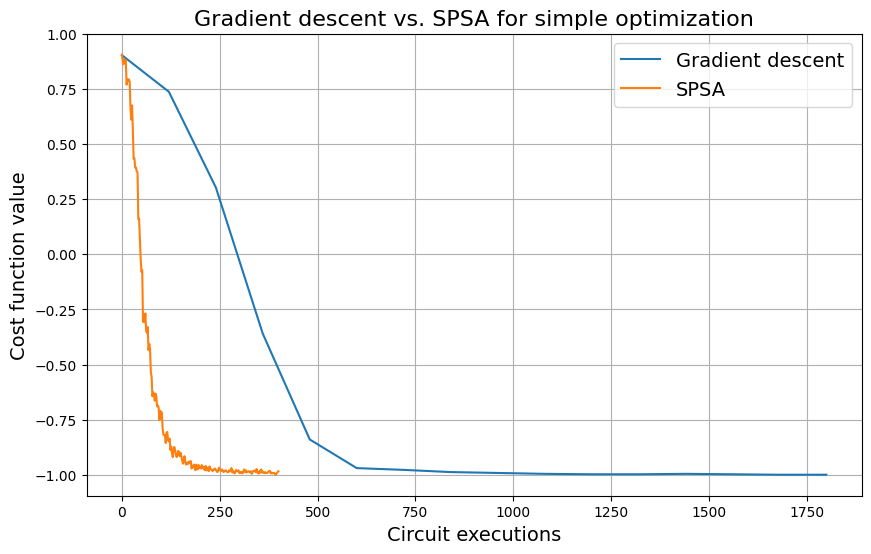

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(exec_history_grad, cost_history_grad, label="Gradient descent")
plt.plot(exec_history_spsa, cost_history_spsa, label="SPSA")

plt.xlabel("Circuit executions", fontsize=14)
plt.ylabel("Cost function value", fontsize=14)
plt.grid()

plt.title("Gradient descent vs. SPSA for simple optimization", fontsize=16)
plt.legend(fontsize=14)
plt.show()

In [11]:
# Computing the ratio of required circuit executions to reach an absolute accuracy of 0.01.
grad_execs_to_prec = exec_history_grad[
    np.where(np.array(cost_history_grad) < -0.99)[0][0]
]
spsa_execs_to_prec = exec_history_spsa[
    np.where(np.array(cost_history_spsa) < -0.99)[0][0]
]
print(f"Circuit execution ratio: {np.round(grad_execs_to_prec/spsa_execs_to_prec, 3)}.")

Circuit execution ratio: 3.333.


In [12]:
# SPSA and the variational quantum eigensolver
# optimizing a real chemical system, namely that of the hydrogen molecule
from pennylane import qchem

symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, -0.6614], [0.0, 0.0, 0.6614]])
molecule = qchem.Molecule(symbols, coordinates)
h2_ham, num_qubits = qchem.molecular_hamiltonian(molecule)
h2_ham_coeffs, h2_ham_ops = h2_ham.terms()
h2_ham = qml.Hamiltonian(qml.math.real(h2_ham_coeffs), h2_ham_ops)

true_energy = -1.136189454088


# Variational ansatz for H_2 - see Intro VQE demo for more details
def ansatz(param, wires):
    qml.BasisState(np.array([1, 1, 0, 0]), wires=wires)
    for i in wires:
        qml.Rot(*param[0, i], wires=i)
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 1])
    for i in wires:
        qml.Rot(*param[1, i], wires=i)

In [13]:
# Running gradient descent on a noisy environment
from qiskit_ibm_runtime.fake_provider import FakeLima
from qiskit_aer import noise

# Load a fake backed to create a noise model, and create a device using that model
noise_model = noise.NoiseModel.from_backend(FakeLima())
noisy_device = qml.device(
    "qiskit.aer", wires=num_qubits, shots=1000, noise_model=noise_model
)


def circuit(param):
    ansatz(param, range(num_qubits))
    return qml.expval(h2_ham)


cost_function = qml.QNode(circuit, noisy_device)

# This random seed was used in the original VQE demo and is known to allow the
# gradient descent algorithm to converge to the global minimum.
np.random.seed(0)
param_shape = (2, num_qubits, 3)
init_param = np.random.normal(0, np.pi, param_shape, requires_grad=True)

# Initialize the optimizer - optimal step size was found through a grid search
opt = qml.GradientDescentOptimizer(stepsize=2.2)

# We spend 2 * 15 circuit evaluations per parameter per step, as there are
# 15 Hamiltonian terms
execs_per_step = 2 * 15 * np.prod(param_shape)
# Run the optimization
cost_history_grad, exec_history_grad = run_optimizer(
    opt, cost_function, init_param, num_steps_grad, 3, execs_per_step
)

final_energy = cost_history_grad[-1]
print(f"\nFinal estimated value of the ground state energy = {final_energy:.8f} Ha")
print(
    f"Distance to the true ground state energy: {np.abs(final_energy - true_energy):.8f} Ha"
)

<ipython-input-13-c29a560df6b4>:6: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  noise_model = noise.NoiseModel.from_backend(FakeLima())
<ipython-input-13-c29a560df6b4>:6: DeprecationWarning:  from_backend using V1 based backend is deprecated as of Aer 0.15 and will be removed no sooner than 3 months from that release date. Please use backends based on V2.
  noise_model = noise.NoiseModel.from_backend(FakeLima())



Running the GradientDescentOptimizer optimizer for 15 iterations.
Step   0: Circuit executions:    0, Cost = 0.39188732657346503
Step   3: Circuit executions: 2160, Cost = -0.48782185511893805
Step   6: Circuit executions: 4320, Cost = -0.9373572858895066
Step   9: Circuit executions: 6480, Cost = -1.0362602293593117
Step  12: Circuit executions: 8640, Cost = -1.0425142912863303
Step  15: Circuit executions: 10800, Cost = -1.0258356304767968

Final estimated value of the ground state energy = -1.02583563 Ha
Distance to the true ground state energy: 0.11035382 Ha


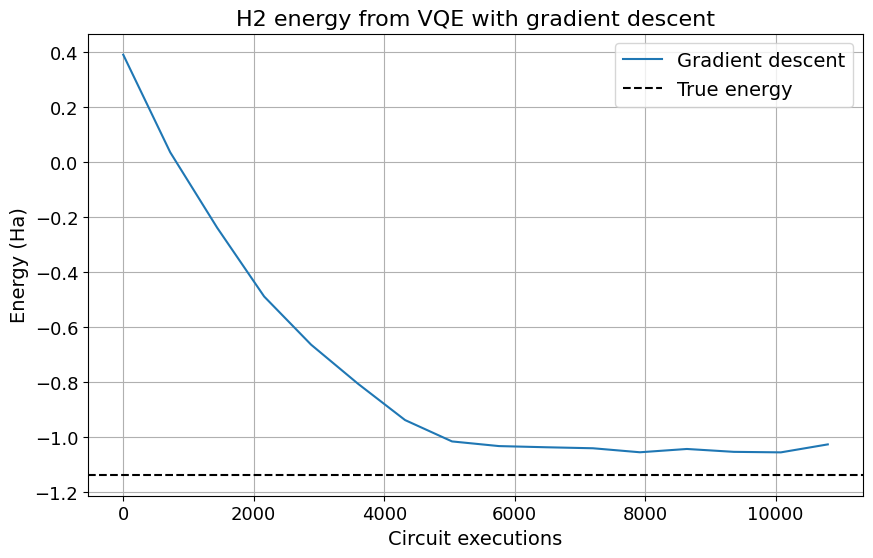

In [14]:
# Plotting the energy during optimization using gradient descent
plt.figure(figsize=(10, 6))

plt.plot(exec_history_grad, cost_history_grad, label="Gradient descent")

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Circuit executions", fontsize=14)
plt.ylabel("Energy (Ha)", fontsize=14)
plt.grid()

plt.axhline(y=true_energy, color="black", linestyle="--", label="True energy")

plt.legend(fontsize=14)

plt.title("H2 energy from VQE with gradient descent", fontsize=16)

plt.show()

In [15]:
# Now optimizing VQE with SPSA
num_steps_spsa = 160
opt = qml.SPSAOptimizer(maxiter=num_steps_spsa, c=0.3, a=1.5)

# We spend 2 * 15 circuit evaluations per step, as there are 15 Hamiltonian terms
execs_per_step = 2 * 15
# Run the optimization
cost_history_spsa, exec_history_spsa = run_optimizer(
    opt, cost_function, init_param, num_steps_spsa, 20, execs_per_step
)
final_energy = cost_history_spsa[-1]

print(f"\nFinal estimated value of the ground state energy = {final_energy:.8f} Ha")
print(
    f"Distance to the true ground state energy: {np.abs(final_energy - true_energy):.8f} Ha"
)


Running the SPSAOptimizer optimizer for 160 iterations.
Step   0: Circuit executions:    0, Cost = 0.36475913647263336
Step  20: Circuit executions:  600, Cost = -0.1599588197187097
Step  40: Circuit executions: 1200, Cost = -0.5589466791192369
Step  60: Circuit executions: 1800, Cost = -0.8663028562349387
Step  80: Circuit executions: 2400, Cost = -1.0050263495163985
Step 100: Circuit executions: 3000, Cost = -1.0196548269530534
Step 120: Circuit executions: 3600, Cost = -1.0381387928050931
Step 140: Circuit executions: 4200, Cost = -1.0481927202573476
Step 160: Circuit executions: 4800, Cost = -1.041242124569867

Final estimated value of the ground state energy = -1.04124212 Ha
Distance to the true ground state energy: 0.09494733 Ha


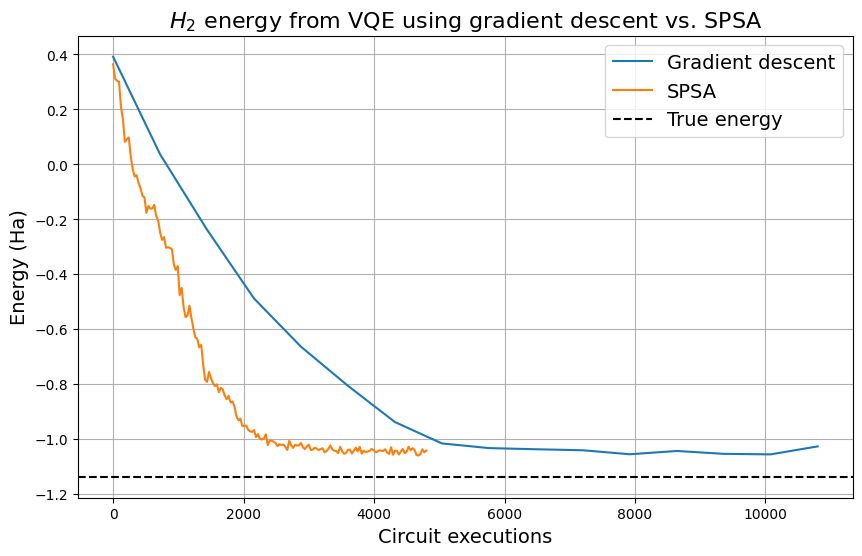

In [16]:
plt.figure(figsize=(10, 6))

plt.plot(exec_history_grad, cost_history_grad, label="Gradient descent")
plt.plot(exec_history_spsa, cost_history_spsa, label="SPSA")
plt.axhline(y=true_energy, color="black", linestyle="--", label="True energy")

plt.title("$H_2$ energy from VQE using gradient descent vs. SPSA", fontsize=16)
plt.xlabel("Circuit executions", fontsize=14)
plt.ylabel("Energy (Ha)", fontsize=14)
plt.grid()

plt.legend(fontsize=14)
plt.show()